In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/datasetV3.zip" /content/
!unzip /content/datasetV3.zip -d /content/dataset/
# !rm -r /content/dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

2024-11-27 19:47:57.031813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 19:48:02.884741: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 19:48:09.263509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/iumyx/danger_ws/devel/lib:/home/iumyx/catkin_ws/devel/lib:/opt/ros/noetic/lib:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins::/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/usr/lib/x86_64-linux-gnu/gazebo-11/plu

Num GPUs Available:  1


### iterate through the folders to create a dataframe of the form filepaths labels

In [2]:
sdir=r'./Bangkit/dataset/Gym Dataset Cropped'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths   labels
0  ./Bangkit/dataset/Gym Dataset Cropped/Dip Bar/...  Dip Bar
1  ./Bangkit/dataset/Gym Dataset Cropped/Dip Bar/...  Dip Bar
2  ./Bangkit/dataset/Gym Dataset Cropped/Dip Bar/...  Dip Bar
3  ./Bangkit/dataset/Gym Dataset Cropped/Dip Bar/...  Dip Bar
4  ./Bangkit/dataset/Gym Dataset Cropped/Dip Bar/...  Dip Bar
labels
Dip Bar               200
KettleBell            200
PullBar               200
Leg Press Machine     200
Dumbells              200
Lat Pulldown          200
Swiss Ball            200
Bench Press           200
Treadmill             200
Elliptical Machine    200
Stair Climber         200
Recumbent Bike        200
Name: count, dtype: int64


### split df into train_df, test_df and valid_df

In [3]:
train_split = 0.8
test_split = 0.1
dummy_split = test_split / (1 - train_split)

train_df, dummy_df = train_test_split(df, train_size=train_split, stratify=df['labels'], random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, stratify=dummy_df['labels'], random_state=123)

print('train_df length:', len(train_df), '  test_df length:', len(test_df), '  valid_df length:', len(valid_df))

train_df length: 1920   test_df length: 240   valid_df length: 240


In [4]:
print(test_df['labels'].unique())

['Leg Press Machine' 'Stair Climber' 'Treadmill' 'Dumbells' 'Swiss Ball'
 'Recumbent Bike' 'Elliptical Machine' 'PullBar' 'KettleBell'
 'Bench Press' 'Lat Pulldown' 'Dip Bar']


### create train, test, valid  generators

In [10]:
height=224
width=224
channels=3
batch_size=32

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  80   test steps:  3
Found 1920 validated image filenames belonging to 12 classes.
Found 240 validated image filenames belonging to 12 classes.
Found 240 validated image filenames belonging to 12 classes.
['Bench Press', 'Dip Bar', 'Dumbells', 'Elliptical Machine', 'KettleBell', 'Lat Pulldown', 'Leg Press Machine', 'PullBar', 'Recumbent Bike', 'Stair Climber', 'Swiss Ball', 'Treadmill']


### create function to show some image examples

In [11]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(15, 15))
    length=len(labels)
    if length<9:
        r=length
    else:
        r=9
    for i in range(r):
        plt.subplot(3, 3, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [12]:
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

In [13]:
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}


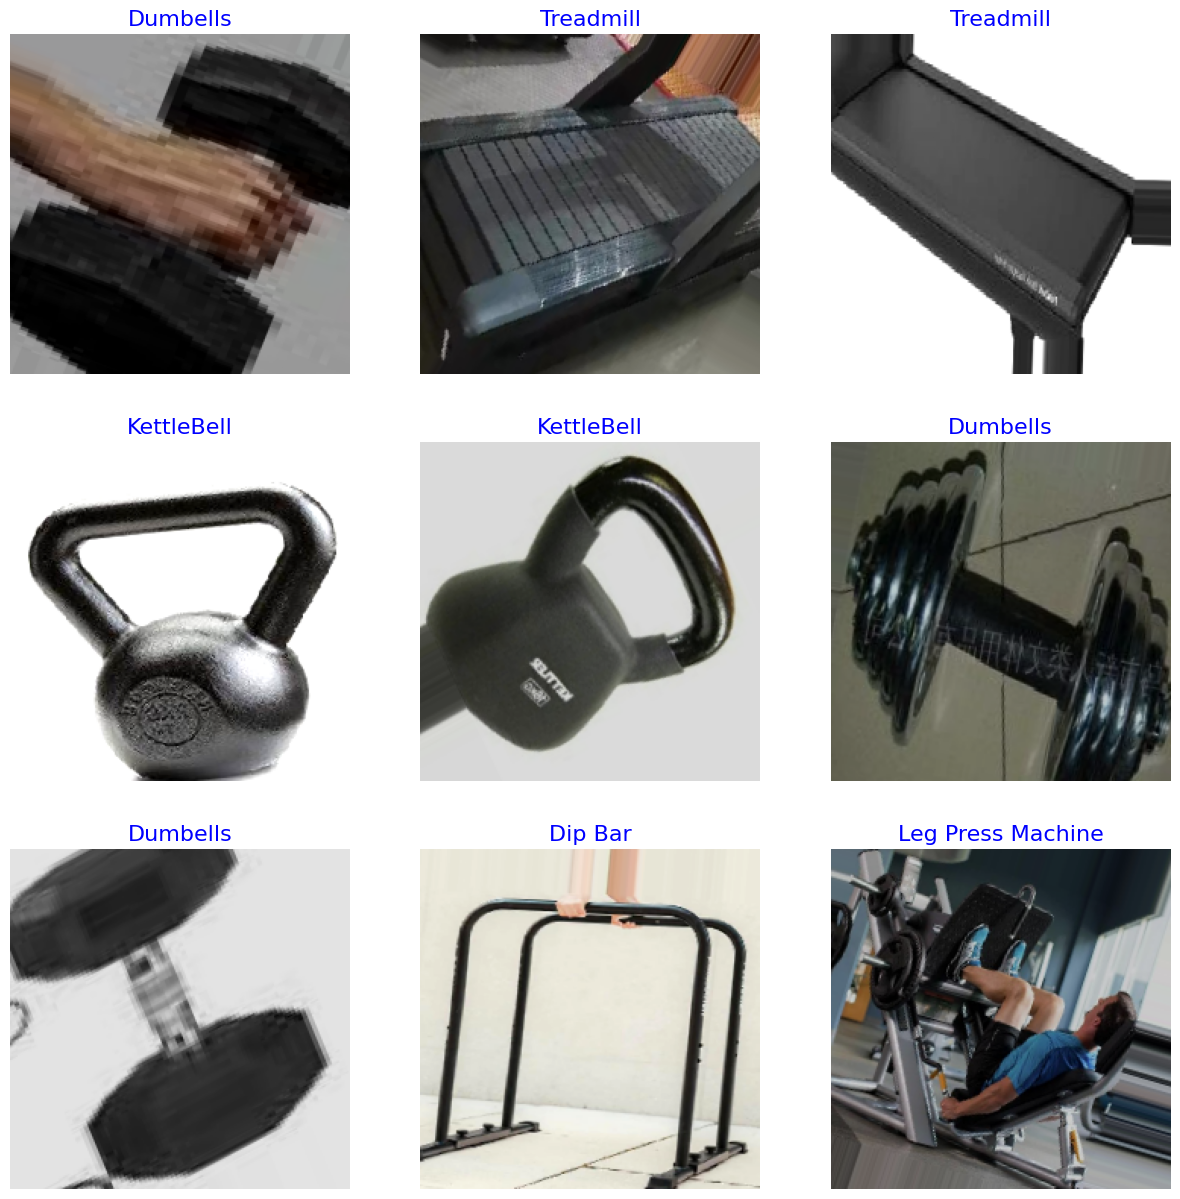

In [14]:
show_image_samples(train_gen)

### create the model

In [15]:
base_model=tf.keras.applications.DenseNet121(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))

2024-11-27 19:49:12.646263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 19:49:12.647702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-27 19:49:12.647892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-27 19:49:12.648020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [16]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [17]:
base_model.trainable = False
# for layer in base_model.layers[:100]:  # Freeze lapisan awal
#     layer.trainable = False
# for layer in base_model.layers[-20:]:  # Unfreeze lapisan terakhir
#     layer.trainable = True

In [ ]:
# new_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [ ]:
# new_base.summary()

In [18]:
model_name='GymLens'
print("Building model with", base_model)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=128, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=128, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=256, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=(1, 1)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(class_count, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Building model with <keras.engine.functional.Functional object at 0x7f82bc647250>


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         1179776   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 128)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 128)         147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 256)         2

In [ ]:
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nStopping training as validation accuracy reached {val_acc:.2f} (≥ {self.target_accuracy:.2f})")
            self.model.stop_training = True

early_stopping = EarlyStoppingAtAccuracy(target_accuracy=0.98)

In [20]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        verbose=1,
        restore_best_weights=True
    )
]

In [21]:
epochs = 100

history=model.fit(
    x=train_gen,
    # batch_size=32,
    epochs=epochs,
    validation_data=valid_gen,
    # class_weight=class_weights,
    callbacks=[callbacks]
)

Epoch 1/100


2024-11-27 19:49:43.521309: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-11-27 19:50:00.401690: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


60/60 [==============================] - 65s 452ms/step - loss: 2.1694 - accuracy: 0.3120 - precision: 0.7407 - recall: 0.0417 - val_loss: 1.8822 - val_accuracy: 0.5958 - val_precision: 1.0000 - val_recall: 0.0042 - lr: 1.0000e-04
Epoch 2/100
60/60 [==============================] - 22s 356ms/step - loss: 1.3065 - accuracy: 0.6464 - precision: 0.9444 - recall: 0.2917 - val_loss: 1.2533 - val_accuracy: 0.8667 - val_precision: 1.0000 - val_recall: 0.1417 - lr: 1.0000e-04
Epoch 3/100
60/60 [==============================] - 21s 350ms/step - loss: 0.8447 - accuracy: 0.8141 - precision: 0.9538 - recall: 0.5484 - val_loss: 0.7152 - val_accuracy: 0.9375 - val_precision: 1.0000 - val_recall: 0.6208 - lr: 1.0000e-04
Epoch 4/100
60/60 [==============================] - 21s 355ms/step - loss: 0.5480 - accuracy: 0.9010 - precision: 0.9676 - recall: 0.7458 - val_loss: 0.4332 - val_accuracy: 0.9375 - val_precision: 0.9949 - val_recall: 0.8083 - lr: 1.0000e-04
Epoch 5/100
60/60 [=====================

### define function to print text in RGB foreground and background colors

In [22]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)
    return

### define function to plot the training data

In [23]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()


### define function to generate the confusion matrix and classification report

In [24]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key

    classes=list(new_dict.values())
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count)
                plot_class.append(value)
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:

        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

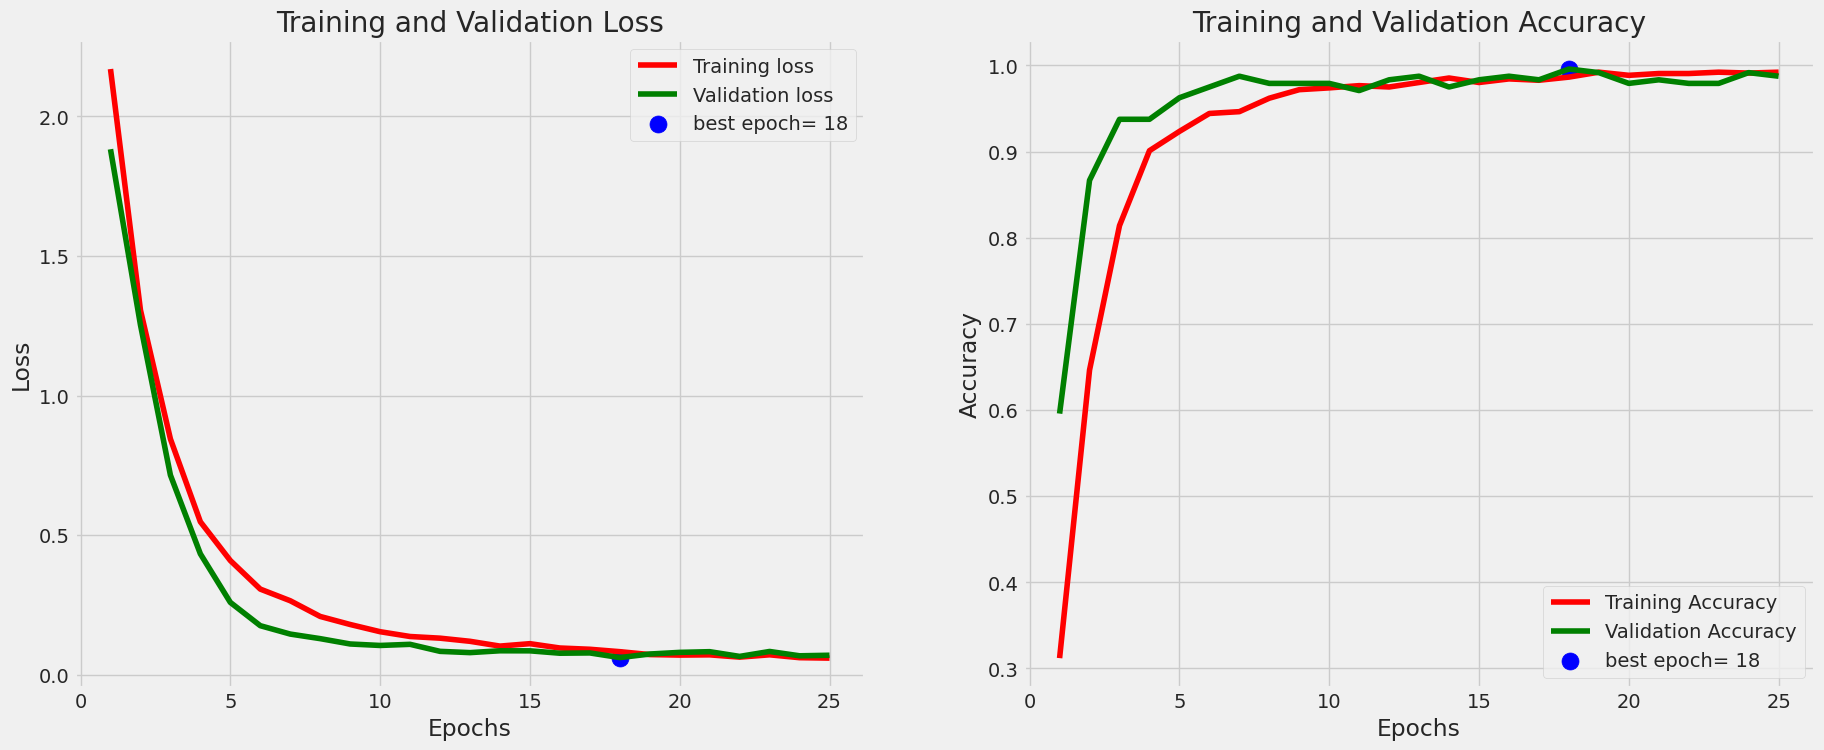

2024-11-27 20:08:43.734931: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-27 20:08:43.736479: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-27 20:08:43.870374: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-27 20:08:43.870407: W tensorflow/core/common_runtime/bfc_allocato

3/3 [==============================] - 6s 320ms/step - loss: 0.0663 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9833
accuracy on the test set is 99.58 %



In [25]:
tr_plot(history,0)
save_dir=r'./'
subject='Gym Exception'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')

### make predictions on test set and generate confusion matrix and classification report

3/3 [==============================] - 2s 350ms/step


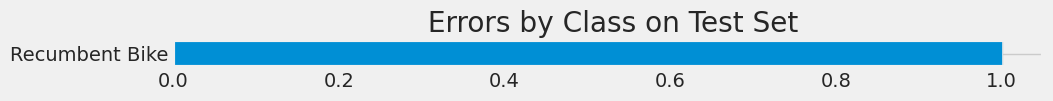

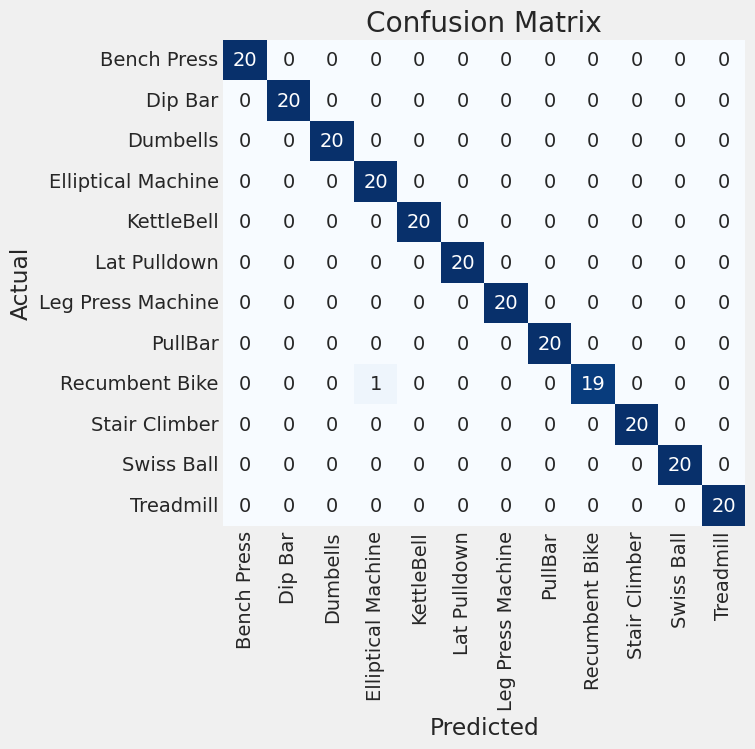

Classification Report:
----------------------
                     precision    recall  f1-score   support

       Bench Press       1.00      1.00      1.00        20
           Dip Bar       1.00      1.00      1.00        20
          Dumbells       1.00      1.00      1.00        20
Elliptical Machine       0.95      1.00      0.98        20
        KettleBell       1.00      1.00      1.00        20
      Lat Pulldown       1.00      1.00      1.00        20
 Leg Press Machine       1.00      1.00      1.00        20
           PullBar       1.00      1.00      1.00        20
    Recumbent Bike       1.00      0.95      0.97        20
     Stair Climber       1.00      1.00      1.00        20
        Swiss Ball       1.00      1.00      1.00        20
         Treadmill       1.00      1.00      1.00        20

          accuracy                           1.00       240
         macro avg       1.00      1.00      1.00       240
      weighted avg       1.00      1.00      1.00  

In [26]:
print_code=0
save_dir=r'./'
subject='Gym Exception'
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

In [ ]:
def get_optimizer():
  # Replace with the optimizer class and arguments used when training the model
  return tf.keras.optimizers.Adam(weight_decay=0.001)  # or tf.keras.optimizers.legacy.Adam(decay=0.001)

model = tf.keras.models.load_model(
    './GymGuide-ML-main/Model2/model.h5',
    custom_objects={'Adam': get_optimizer}  # Assuming Adam was the optimizer
)

In [27]:
def prepare_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

image_path = './Bangkit/dataset/tes/pullBar_92.jpg'
image_to_predict = prepare_image(image_path)

class_names = ['Bench Press', 'Dip Bar', 'Dumbells', 'Elliptical Machine', 'KettleBell', 'Lat Pulldown', 'Leg Press Machine', 'PullBar', 'Recumbent Bike', 'Stair Climber', 'Swiss Ball', 'Treadmill']

predictions = model.predict(image_to_predict)
predicted_class_index = np.argmax(predictions, axis=1)

if len(predicted_class_index) > 0:
    predicted_class_name = class_names[predicted_class_index[0]]
    print(f'Predicted class: {predicted_class_name}')
else:
    print("No predictions were made.")

1/1 [==============================] - 3s 3s/step
Predicted class: PullBar


In [ ]:
# !rm -r /content/tes/.ipynb_checkpoints

1/1 [==============================] - 0s 24ms/step


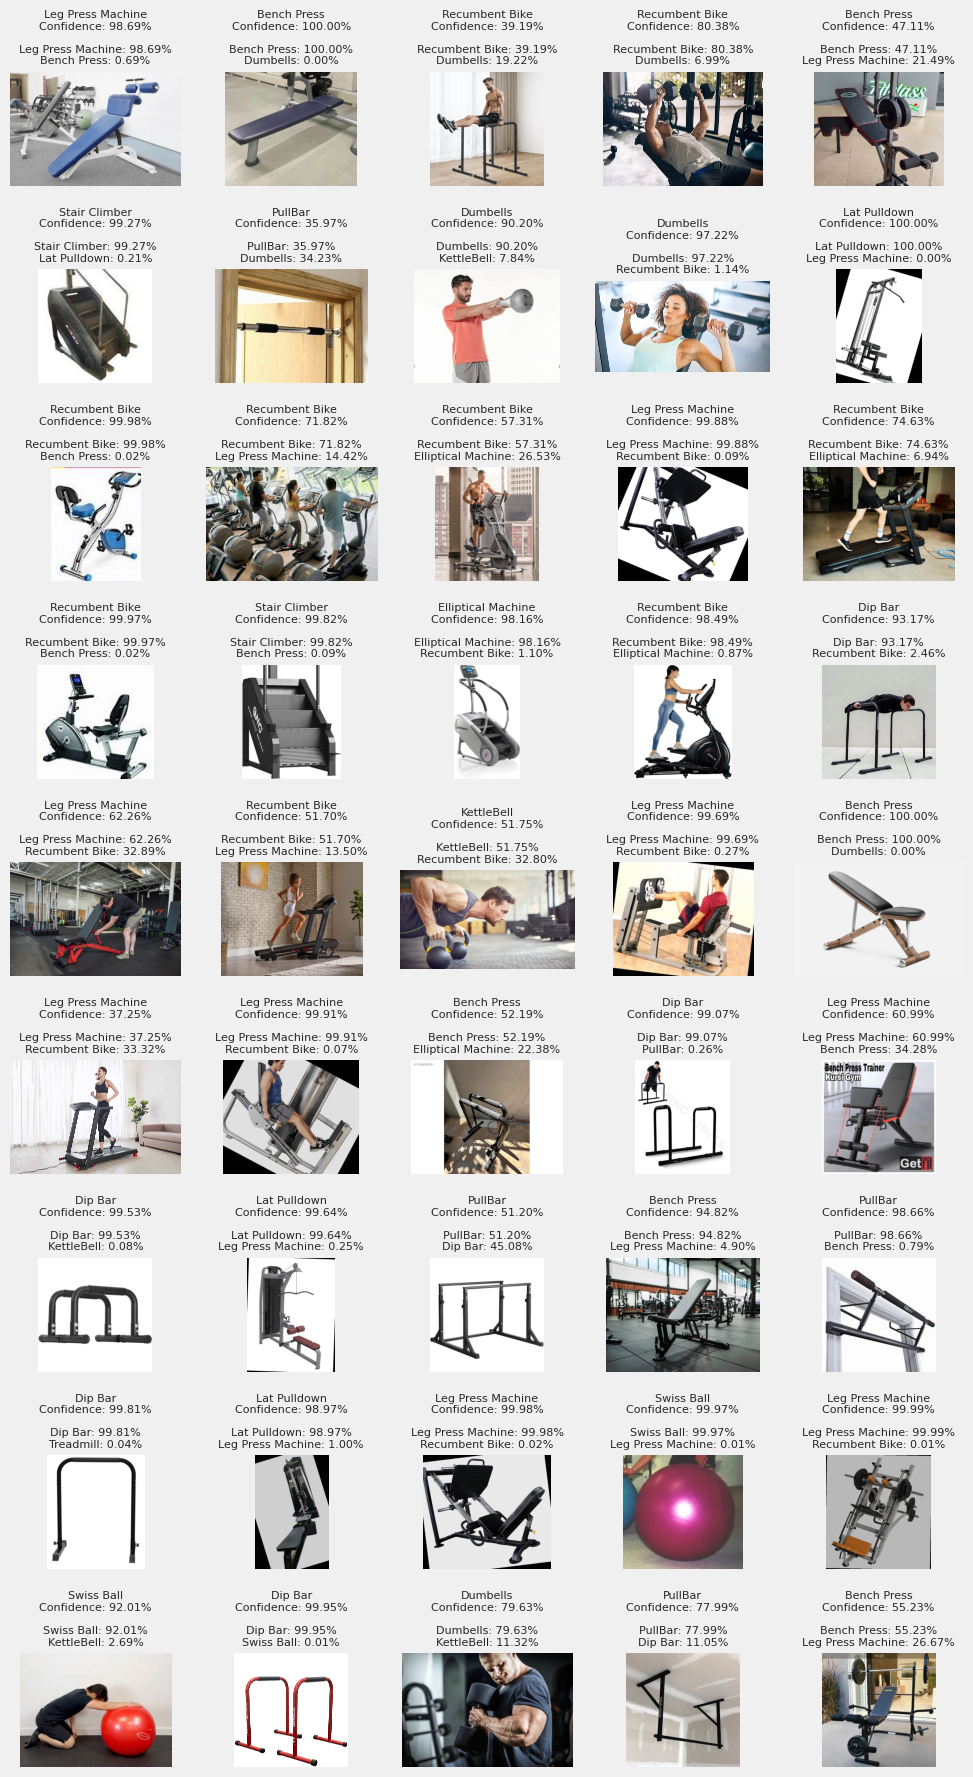

In [28]:
directory_path = './Bangkit/dataset/tes'
class_names = ['Bench Press', 'Dip Bar', 'Dumbells', 'Elliptical Machine', 'KettleBell', 'Lat Pulldown', 'Leg Press Machine', 'PullBar', 'Recumbent Bike', 'Stair Climber', 'Swiss Ball', 'Treadmill']
fig, axes = plt.subplots(nrows=9, ncols=5, figsize=(10, 18))
axes = axes.flatten()

for i, filename in enumerate(os.listdir(directory_path)):
    image_path = os.path.join(directory_path, filename)
    image = prepare_image(image_path)

    predictions = model.predict(image)
    predicted_class_index = np.argsort(predictions[0])[-2:][::-1]
    predicted_class_name = [class_names[idx] for idx in predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100

    img = tf.keras.preprocessing.image.load_img(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')


    confidence_text = "\n".join([f"{predicted_class_name[j]}: {confidence[j]:.2f}%" for j in range(2)])
    axes[i].set_title(f"{predicted_class_name[0]}\nConfidence: {confidence[0]:.2f}%\n\n{confidence_text}", fontsize=8)

    if i == 44:
        break

plt.tight_layout()
plt.show()


In [29]:
model.save('./Bangkit/out/gym_model_densenet121_9958.h5')

In [30]:
imp_model = load_model('./Bangkit/out//gym_model_densenet121_9958.h5')

# Evaluasi model
results = imp_model.evaluate(valid_gen)
print("Validation Results:", results)

# Prediksi
predictions = imp_model.predict(test_gen)

8/8 [==============================] - 3s 129ms/step - loss: 0.0617 - accuracy: 0.9958 - precision: 1.0000 - recall: 0.9875
Validation Results: [0.06165747344493866, 0.9958333373069763, 1.0, 0.987500011920929]
3/3 [==============================] - 2s 348ms/step


In [32]:
h5_model_path = "./Bangkit/out/gym_model_densenet121_9958.h5"

model = tf.keras.models.load_model(h5_model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model_densenet121_9958.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpii8r_ehi/assets


INFO:tensorflow:Assets written to: /tmp/tmpii8r_ehi/assets
2024-11-27 20:27:57.447880: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-11-27 20:27:57.447935: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-11-27 20:27:57.458825: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpii8r_ehi
2024-11-27 20:27:57.536554: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-11-27 20:27:57.536623: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpii8r_ehi
2024-11-27 20:27:57.727835: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-11-27 20:27:57.799834: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-11-27 20:27:58.889110: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [ ]:
from google.colab import drive
drive.mount('/Bangkit/drive')

In [ ]:
!cp "/content/gym_model_densenet121_9833.h5" "/content/drive/MyDrive/Colab Notebooks"